# Crime Prediction and Clustering using Spark MLlib

## 1. Initialize Spark Session

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Chicago Crime Prediction") \
    .getOrCreate()

## 2. Load Data from S3

In [ ]:
# Load preprocessed CSV from S3 (path assumed to be set)
df = spark.read.csv("s3a://chicago-crime-data-kinjal/processed/crime_processed.csv", header=True, inferSchema=True)
df.show(5)

## 3. Feature Engineering

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler

df = df.dropna(subset=["primary_type", "arrest", "day_of_week", "hour"])

# Index categorical features
string_indexers = [
    StringIndexer(inputCol="primary_type", outputCol="primary_type_index"),
    StringIndexer(inputCol="day_of_week", outputCol="day_of_week_index"),
    StringIndexer(inputCol="arrest", outputCol="label")
]

for indexer in string_indexers:
    df = indexer.fit(df).transform(df)

# Assemble features
vec_assembler = VectorAssembler(
    inputCols=["primary_type_index", "day_of_week_index", "hour"],
    outputCol="features"
)
df = vec_assembler.transform(df)
df.select("features", "label").show(5)

## 4. Random Forest Classification

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split data
train, test = df.randomSplit([0.8, 0.2], seed=42)

# Train model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
rf_model = rf.fit(train)

# Predict
rf_predictions = rf_model.transform(test)

# Evaluate
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator.evaluate(rf_predictions)
print("F1 Score:", f1)

## 5. KMeans Clustering

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans(featuresCol="features", k=4)
k_model = kmeans.fit(df)
k_preds = k_model.transform(df)

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(k_preds)
print("Silhouette Score:", silhouette)

k_preds.select("primary_type", "day_of_week", "hour", "prediction").show(5)

## 6. Visualizations (Pandas + Seaborn)

In [ ]:
# Convert to Pandas for plotting
sample_pd = k_preds.select("primary_type", "day_of_week", "hour", "prediction").toPandas()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(data=sample_pd, x="prediction", hue="day_of_week")
plt.title("Crime Clusters by Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Additional Logic from `models.ipynb`

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
#spark imports
from pyspark import SparkContext
from pyspark.sql import DataFrame

from pyspark.sql.types import *
from pyspark.sql.functions import format_number, when, col, array, udf, lit

import csv
import pandas as pd
import numpy as np
import pyspark.sql.functions as F

from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.mllib.tree import RandomForest
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [0]:
spark = SparkSession.builder.appName("Project - Chicago crime")\
.config("spark.some.config.option", "some-value")\
.config("spark.driver.memory", "20g")\
.getOrCreate()

In [0]:
crimes_schema = StructType([StructField("Date", StringType(), True ),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("Year", IntegerType(), True),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),        
                            ])

In [11]:
dataset=data.withColumn("Day", F.split(data.Date, " ")[0])
dataset=dataset.withColumn("Day", F.to_date(dataset.Day, "MM/dd/yyyy"))
dataset=dataset.withColumn("Month", F.month(dataset.Day))
dataset=dataset.withColumn("Week", F.weekofyear(dataset.Day))
dataset=dataset.drop('Day')
dataset=dataset.drop('Date')
dataset.take(5)

[Row(Primary Type='PUBLIC PEACE VIOLATION', Location Description='AIRCRAFT', Arrest=False, Ward='41', Year=2019, Latitude=42.002816387, Longitude=-87.90609433, Month=1, Week=1),
 Row(Primary Type='BATTERY', Location Description='STREET', Arrest=False, Ward='42', Year=2019, Latitude=41.88336939, Longitude=-87.633860272, Month=3, Week=11),
 Row(Primary Type='THEFT', Location Description='RESIDENTIAL YARD (FRONT/BACK)', Arrest=False, Ward='4', Year=2019, Latitude=41.825346902, Longitude=-87.606780575, Month=3, Week=11),
 Row(Primary Type='BATTERY', Location Description='RESIDENCE', Arrest=False, Ward='49', Year=2019, Latitude=42.016541612, Longitude=-87.672499325, Month=3, Week=11),
 Row(Primary Type='OTHER OFFENSE', Location Description='STREET', Arrest=False, Ward='4', Year=2019, Latitude=41.825298645, Longitude=-87.6069609, Month=3, Week=11)]

In [0]:
targetDf = dataset.withColumn("Primary Type", \
              when((dataset["Primary Type"] == 'KIDNAPPING') | (dataset["Primary Type"] == 'HOMICIDE'),'OTHER OFFENSE').otherwise(dataset['Primary Type']))

In [13]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, IndexToString, OneHotEncoderEstimator
targetDf.printSchema()

root
 |-- Primary Type: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Week: integer (nullable = true)



**RANDOM FOREST : Use "Week" as feature -**


In [14]:
vector_assembler = VectorAssembler(inputCols = ["Week"], outputCol="features")

df_temp = vector_assembler.transform(targetDf)

featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)

labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf  = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100,impurity='gini', maxBins=128)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

+--------------+------------+
|predictedLabel|Primary Type|
+--------------+------------+
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
+--------------+------------+
only showing top 20 rows

accuracy = 0.226515
f1 score = 0.0836666
+--------------+------+
|predictedLabel| count|
+--------------+------+
|         THEFT|879124|
+--------------+------+



**RANDOM FOREST : Added more features -**

In [0]:
from pyspark.ml.feature import OneHotEncoderEstimator
locationIndexer = StringIndexer(inputCol="Location Description", outputCol="indexedLocation")\
                .fit(targetDf)\
                .transform(targetDf)
encoded_data = OneHotEncoderEstimator(inputCols=["indexedLocation"],outputCols=["encodedLocation"])\
        .fit(locationIndexer)\
        .transform(locationIndexer)

In [17]:
#locationDescIndexer = StringIndexer(inputCol="Location Description", outputCol="locDespFeatures")

#loc_des_indexer_model = locationDescInd#exer.fit(targetDf)
#loc_des_indexed_data= loc_des_indexer_model.transform(targetDf)

vector_assembler = VectorAssembler(inputCols = ["Latitude", "Longitude", "Arrest", "encodedLocation"], outputCol="features")
df_temp = vector_assembler.transform(encoded_data)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10,impurity='gini', maxBins=32)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

+--------------+------------+
|predictedLabel|Primary Type|
+--------------+------------+
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
+--------------+------------+
only showing top 20 rows

accuracy = 0.291977
f1 score = 0.177746
+------------------+------+
|    predictedLabel| count|
+------------------+------+
|             THEFT|649816|
|           BATTERY|219221|
|DECEPTIVE PRACTICE|  1592|
|         NARCOTICS|  8195|
+-----------------

**Using a grid search and 4-fold cross validation -** 

In [0]:
from pyspark.sql.types import IntegerType
targetDf = targetDf.withColumn("Ward", targetDf["Ward"].cast(IntegerType()))

In [0]:
locationIndexer = StringIndexer(inputCol="Location Description", outputCol="indexedLocation")\
                .fit(targetDf)\
                .transform(targetDf)
encoded_data = OneHotEncoderEstimator(inputCols=["indexedLocation"],outputCols=["encodedLocation"])\
        .fit(locationIndexer)\
        .transform(locationIndexer)

In [22]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

vector_assembler = VectorAssembler(inputCols = ["Latitude", \
                            "Longitude", "Arrest", "Week", "Ward","encodedLocation"], outputCol="features")

indexed_data = vector_assembler.transform(encoded_data)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(indexed_data)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(indexed_data)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = indexed_data.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

paramGrid = ParamGridBuilder()\
            .addGrid(rf.numTrees, [3,10])\
            .addGrid(rf.maxBins, [32,64])\
            .addGrid(rf.maxDepth, [5,10])\
            .addGrid(rf.impurity,['gini','entropy'])\
            .build()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

crossval = CrossValidator(\
                          estimator=pipeline,\
                         estimatorParamMaps=paramGrid,\
                         evaluator=evaluator,\
                         numFolds=4)


model = crossval.fit(trainingData)


predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)
print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

bestPipeline = model.bestModel
bestLRModel = bestPipeline.stages[2]
bestParams = bestLRModel.extractParamMap()
print("\n".join("{}\t{}".format(k, v) for k, v in bestParams.items()))

+--------------+------------+
|predictedLabel|Primary Type|
+--------------+------------+
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|     NARCOTICS|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|     NARCOTICS|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
|         THEFT|     ASSAULT|
+--------------+------------+
only showing top 20 rows

accuracy = 0.346422
f1 score = 0.241841
+------------------+------+
|    predictedLabel| count|
+------------------+------+
| CRIMINAL TRESPASS|  1251|
|             THEFT|517190|
|           BATTERY|171714|
|DECEPTIVE PRACTICE|  5971|
|         NARCOTIC

### Dependencies:

### Initialize Spark:

In [2]:
spark = SparkSession.builder.appName("Project - Chicago crime")\
.config("spark.some.config.option", "some-value")\
.config("spark.driver.memory", "8g")\
.config("spark.driver.cores", "3")\
.getOrCreate()

In [22]:
crimes_schema = StructType([StructField("ID", StringType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("Community Area", StringType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", DoubleType(), True),
                            StructField("Y Coordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

### Read the data (csv file):

In [3]:
dataset =spark.read.option("header", "True")\
        .option("inferSchema", "true").csv("/media/hai-feng/Work/Downloads/crimes-in-chicago/Crimes_-_2001_to_present.csv")

In [4]:
dataset.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



### Check the data and the schema:

In [5]:
dataset.limit(5).toPandas().head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,8,45,11,None,None,2001,08/05/2017 03:50:08 PM,None,None,None
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21,73,02,None,None,2017,02/11/2018 03:57:41 PM,None,None,None
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18,70,05,None,None,2017,02/11/2018 03:57:41 PM,None,None,None
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20,42,06,None,None,2017,02/11/2018 03:57:41 PM,None,None,None
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42,32,02,None,None,2017,02/11/2018 03:57:41 PM,None,None,None


### 1. Only select data that after 2009.
### 2. Drop some crimes that are not important.

In [4]:
dataset=dataset.filter((dataset['Year'] >2009) & (dataset['Year'] !=2020))
dataset=dataset.filter((dataset['Primary Type']!='STALKING')&
                             (dataset['Primary Type']!='OBSCENITY')&
                             (dataset['Primary Type']!='NON-CRIMINAL (SUBJECT SPECIFIED)')&
                             (dataset['Primary Type']!='GAMBLING')&
                             (dataset['Primary Type']!='NON - CRIMINAL')&
                             (dataset['Primary Type']!='LIQUOR LAW VIOLATION')&
                             (dataset['Primary Type']!='PUBLIC INDECENCY')&
                             (dataset['Primary Type']!='HUMAN TRAFFICKING')&
                             (dataset['Primary Type']!='INTIMIDATION')&
                             (dataset['Primary Type']!='CONCEALED CARRY LICENSE VIOLATION')&
                             (dataset['Primary Type']!='NON-CRIMINAL')&
                             (dataset['Primary Type']!='OTHER NARCOTIC VIOLATION'))

### Extract Day, Month, WeekDay, Hour from Date column:

In [5]:
dataset=dataset.withColumn("Day", F.split(dataset.Date, " ")[0])
dataset=dataset.withColumn("Day", F.to_date(dataset.Day, "MM/dd/yyyy"))
dataset=dataset.withColumn("Month", F.month(dataset.Day))
dataset=dataset.withColumn("WeekDay", F.dayofweek(dataset.Day))
dataset=dataset.withColumn("Hour", F.split(F.split(dataset.Date," ")[1], ":")[0].cast("int"))
dataset=dataset.na.drop()
dataset.limit(5).toPandas().head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Day,Month,WeekDay,Hour
0,11665567,JC234307,04/10/2019 04:37:00 PM,102XX S VERNON AVE,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,"SCHOOL, PUBLIC, BUILDING",False,False,...,1837225,2019,08/03/2019 04:02:13 PM,41.708589,-87.612583,"(41.708589, -87.612583094)",2019-04-10,4,4,4
1,11667963,JC235212,04/12/2019 04:08:00 PM,032XX N KEELER AVE,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,True,...,1921408,2019,10/02/2019 04:13:24 PM,41.940298,-87.732066,"(41.940297617, -87.732066473)",2019-04-12,4,6,4
2,11667968,JC237058,04/19/2019 01:57:00 PM,002XX N LARAMIE AVE,1752,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,False,True,...,1901165,2019,03/18/2020 03:52:17 PM,41.884865,-87.755230,"(41.884865037, -87.755230327)",2019-04-19,4,6,1
3,11668309,JC238187,04/25/2019 05:20:00 PM,108XX S DR MARTIN LUTHER KING JR DR,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,1833222,2019,06/30/2019 03:56:27 PM,41.697609,-87.613508,"(41.697609261, -87.613507612)",2019-04-25,4,5,5
4,11692179,JC261724,05/13/2019 05:26:00 PM,090XX S RACINE AVE,0560,ASSAULT,SIMPLE,STREET,False,False,...,1844927,2019,06/30/2019 03:56:27 PM,41.729973,-87.653167,"(41.729973132, -87.653166753)",2019-05-13,5,2,5


### Check the number of crimes:

In [39]:
dataset.groupby('Primary Type').count().show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|OFFENSE INVOLVING...| 22415|
|CRIMINAL SEXUAL A...|   115|
|PUBLIC PEACE VIOL...| 24065|
|               ARSON|  4416|
|   CRIMINAL TRESPASS| 75100|
|             ASSAULT|192553|
| MOTOR VEHICLE THEFT|128892|
|               THEFT|666404|
|             BATTERY|535685|
|             ROBBERY|114454|
|            HOMICIDE|  5314|
| CRIM SEXUAL ASSAULT| 14033|
|        PROSTITUTION| 14640|
|  DECEPTIVE PRACTICE|148538|
|         SEX OFFENSE| 10181|
|     CRIMINAL DAMAGE|315155|
|           NARCOTICS|253760|
|       OTHER OFFENSE|179581|
|          KIDNAPPING|  2199|
|            BURGLARY|169909|
+--------------------+------+
only showing top 20 rows



### Merge similar crime types to make the data more balance:

In [6]:
dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'CRIM SEXUAL ASSAULT') | \
                                    (dataset["Primary Type"] == 'PROSTITUTION') ,'SEX OFFENSE').otherwise(dataset['Primary Type']))
dataset=dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'WEAPONS VIOLATION') | \
                                    (dataset["Primary Type"] == 'INTERFERENCE WITH PUBLIC OFFICER') ,'PUBLIC PEACE VIOLATION').otherwise(dataset['Primary Type']))
dataset=dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'ARSON') ,'CRIMINAL TRESPASS').otherwise(dataset['Primary Type']))

### Check the number of crimes after merge:

In [9]:
dataset.groupby('Primary Type').count().orderBy('count', ascending=False).show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|               THEFT|666404|
|             BATTERY|535685|
|     CRIMINAL DAMAGE|315155|
|           NARCOTICS|253760|
|             ASSAULT|192553|
|       OTHER OFFENSE|179581|
|            BURGLARY|169909|
|  DECEPTIVE PRACTICE|148538|
| MOTOR VEHICLE THEFT|128892|
|             ROBBERY|114454|
|   CRIMINAL TRESPASS| 79516|
|PUBLIC PEACE VIOL...| 77062|
|         SEX OFFENSE| 38854|
|OFFENSE INVOLVING...| 22415|
|            HOMICIDE|  5314|
|          KIDNAPPING|  2199|
|CRIMINAL SEXUAL A...|   115|
+--------------------+------+



### Drop all the invalid data:

In [7]:
dataset=dataset.na.drop()

### Check the number of crimes using bar chart:

Text(0, 0.5, 'Crime Type')

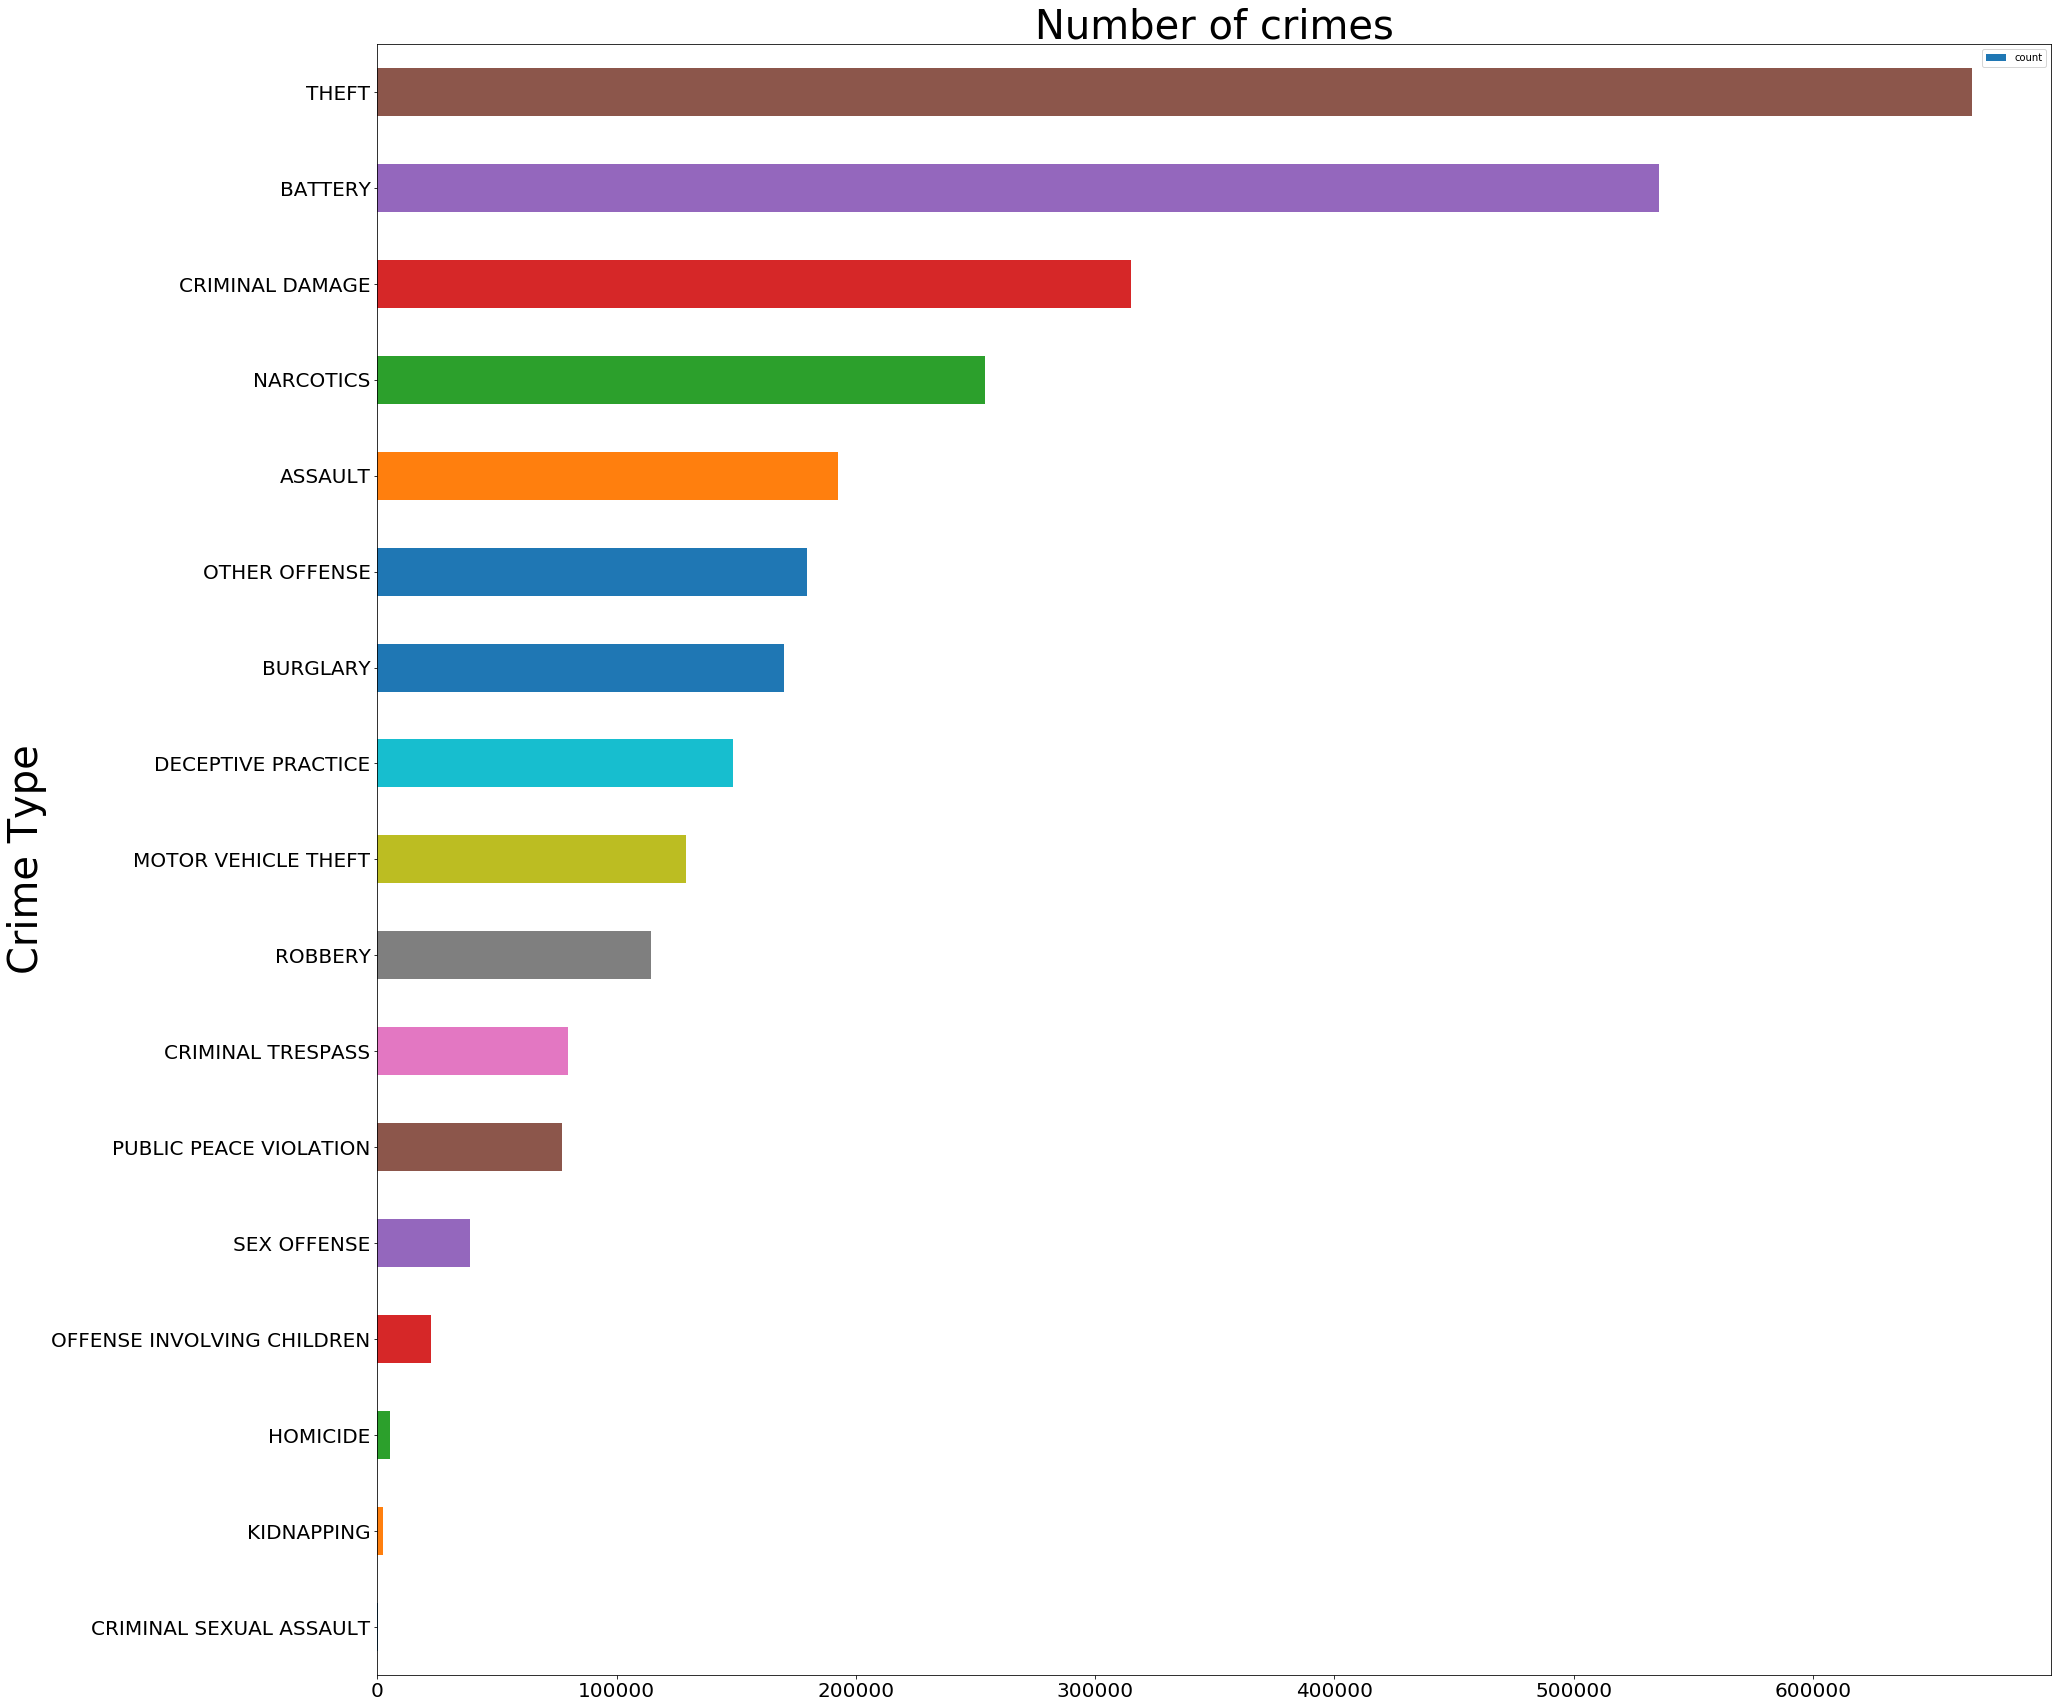

In [11]:
dataset.groupBy("Primary Type")\
        .count().toPandas().sort_values(by='count')\
        .plot(x='Primary Type',y='count',\
                      sort_columns=True,kind='barh', \
                      figsize=(30, 30),fontsize=20)
plt.title("Number of crimes", fontsize=40)
plt.ylabel('Crime Type', fontsize=40)

### Check the crimes' decription to have a literal concept about the crimes:

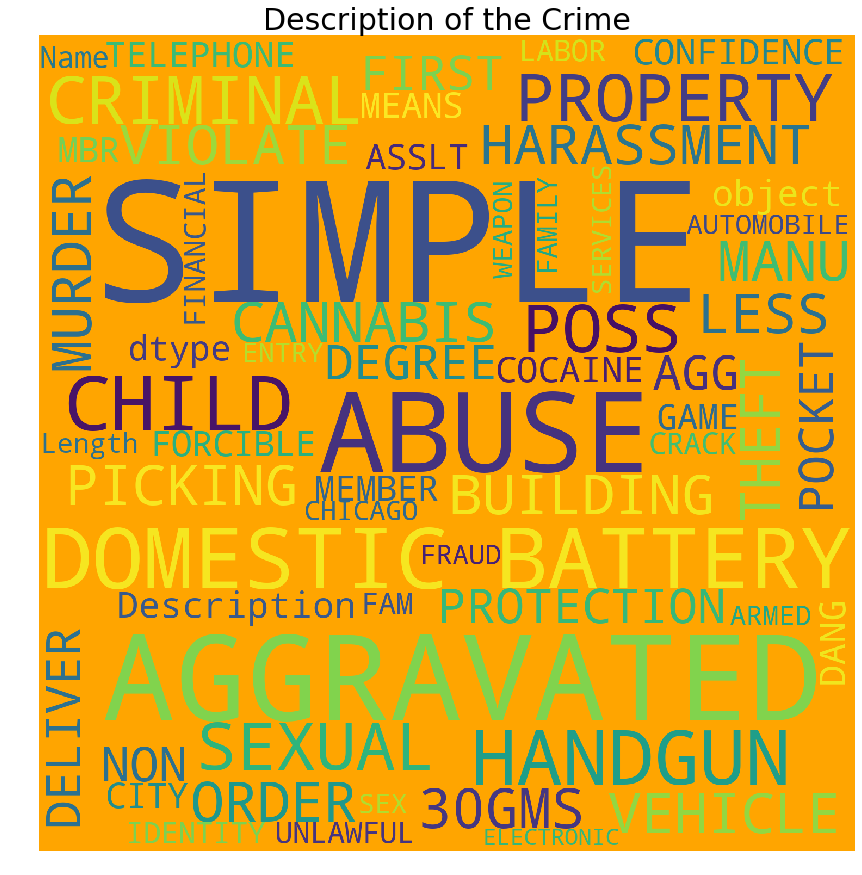

In [12]:
from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = (15, 15)
plt.style.use('fast')
wc = WordCloud(background_color = 'orange', \
               width = 1500, height = 1500)\
               .generate(str(dataset.toPandas()['Description']))
plt.title('Description of the Crime', fontsize = 30)
plt.imshow(wc)
plt.axis('off')
plt.show()

### List top 10 blocks that have most crimes:

Text(0.5, 0, 'Block Name')

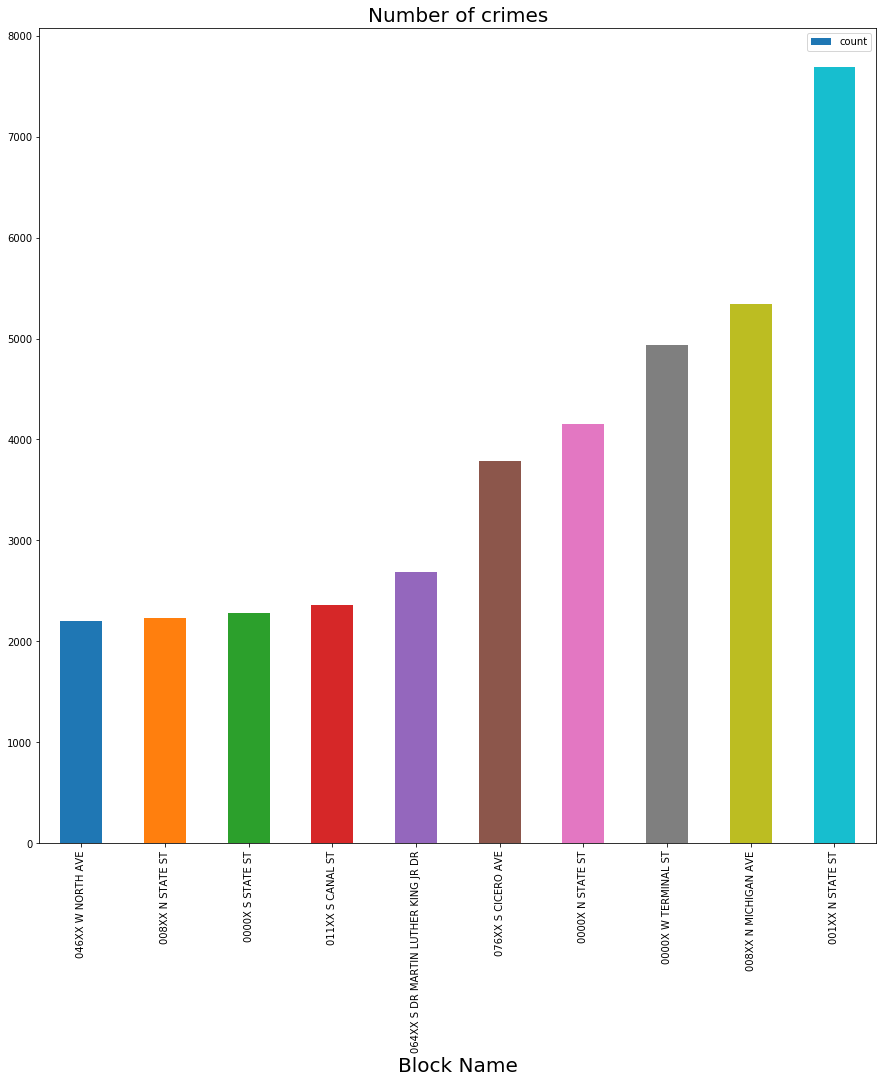

In [13]:
dataset.groupBy("Block")\
        .count().sort('count', ascending=False).limit(10)\
        .toPandas().sort_values(by='count')\
        .plot(x='Block',y='count',\
         sort_columns=True,kind='bar', \
         figsize=(15, 15),fontsize=10)
plt.title("Number of crimes", fontsize=20)
plt.xlabel('Block Name', fontsize=20)

### Using head map to check hot spot of crimes.
From heat map we can see that crimes have cluster pattern, so that we have the possibility to predict it.

In [14]:
import folium
from folium import plugins
from folium.plugins import HeatMap

latitude = 41.864073157
longitude = -87.706818608


heatMap = folium.Map(location=[latitude, longitude], 
                 tiles = "OpenStreetMap",
                zoom_start=12)
hotspot = dataset.toPandas().head(20000)
heat_data = [[row['Latitude'],row['Longitude']] for index, row in hotspot.iterrows()]
HeatMap(heat_data, radius=10).add_to(heatMap)

heatMap

## The following we will use Random Forest algorithm to train and test the model:

### Only use "Latitude" and "Longitude" as features:

In [8]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", \
                            "Longitude"], outputCol="features")
df_temp = vector_assembler.transform(dataset)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100,impurity='gini', maxBins=128)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

+--------------+------------+
|predictedLabel|Primary Type|
+--------------+------------+
|         THEFT|    HOMICIDE|
|       BATTERY|    HOMICIDE|
|         THEFT|    HOMICIDE|
|       BATTERY|    HOMICIDE|
|       BATTERY|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|         THEFT|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|       BATTERY|    HOMICIDE|
|         THEFT|    HOMICIDE|
|       BATTERY|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|       BATTERY|    HOMICIDE|
|       BATTERY|    HOMICIDE|
|       BATTERY|    HOMICIDE|
|       BATTERY|    HOMICIDE|
|       BATTERY|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|       BATTERY|    HOMICIDE|
+--------------+------------+
only showing top 20 rows

accuracy = 0.263304
f1 score = 0.175809
+--------------+------+
|predictedLabel| count|
+--------------+------+
|         THEFT|373663|
|       BATTERY|410082|
|     NARCOTICS| 94418|
+--------------+------+



### Use all the availbel features: "Latitude", "Longitude", "Arrest", "Beat", "Ward","Community Area","WeekDay","Hour"

In [10]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", "Longitude", "Arrest", "Beat", "Ward","Location Description","WeekDay","Hour"], outputCol="features")
df_temp = vector_assembler.transform(dataset)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10,impurity='gini', maxBins=32)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

+--------------+------------+
|predictedLabel|Primary Type|
+--------------+------------+
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|         THEFT|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|         THEFT|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|       BATTERY|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
+--------------+------------+
only showing top 20 rows

accuracy = 0.308645
f1 score = 0.198231
+--------------+------+
|predictedLabel| count|
+--------------+------+
|         THEFT|457505|
|       BATTERY|230136|
|     NARCOTICS|192421|
+--------------+------+



### Encoding "Location description":

In [13]:
locationIndexer = StringIndexer(inputCol="Location Description", outputCol="indexedLocation")\
                .fit(dataset)\
                .transform(dataset)
encoded_data = OneHotEncoderEstimator(inputCols=["indexedLocation"],outputCols=["encodedLocation"])\
        .fit(locationIndexer)\
        .transform(locationIndexer)

### Add "encodedLocation" to model:

In [14]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", "Longitude", "Arrest", "Beat", "Ward","Community Area","WeekDay","Hour","encodedLocation"], outputCol="features")
df_temp = vector_assembler.transform(encoded_data)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10,impurity='gini', maxBins=32)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

+--------------+------------+
|predictedLabel|Primary Type|
+--------------+------------+
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|         THEFT|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|         THEFT|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|         THEFT|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
+--------------+------------+
only showing top 20 rows

accuracy = 0.353001
f1 score = 0.231788
+------------------+------+
|    predictedLabel| count|
+------------------+------+
|             THEFT|509051|
|           BATTERY|218091|
|DECEPTIVE PRACTICE|   991|
|         NARCOTICS|149882|
+-----------------

### Using a grid search, 4-fold cross validation, and change to pipeline runner, finally get the best parameter:

In [17]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", \
                            "Longitude", "Arrest", "Beat", "Ward","Community Area","WeekDay","Hour","encodedLocation"], outputCol="features")


indexed_data = vector_assembler.transform(encoded_data)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(indexed_data)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(indexed_data)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = indexed_data.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

paramGrid = ParamGridBuilder()\
            .addGrid(rf.numTrees, [3,10])\
            .addGrid(rf.maxBins, [32,64])\
            .addGrid(rf.maxDepth, [5,10])\
            .addGrid(rf.impurity,['gini','entropy'])\
            .build()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

crossval = CrossValidator(\
                          estimator=pipeline,\
                         estimatorParamMaps=paramGrid,\
                         evaluator=evaluator,\
                         numFolds=4)


model = crossval.fit(trainingData)


predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)
print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

bestPipeline = model.bestModel
bestLRModel = bestPipeline.stages[2]
bestParams = bestLRModel.extractParamMap()
print("\n".join("{}\t{}".format(k, v) for k, v in bestParams.items()))

+--------------+------------+
|predictedLabel|Primary Type|
+--------------+------------+
|     NARCOTICS|    HOMICIDE|
|         THEFT|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|         THEFT|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|       BATTERY|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
|     NARCOTICS|    HOMICIDE|
+--------------+------------+
only showing top 20 rows

accuracy = 0.368634
f1 score = 0.25422
+------------------+------+
|    predictedLabel| count|
+------------------+------+
|             THEFT|457772|
|           BATTERY|266535|
|DECEPTIVE PRACTICE|  3594|
|         NARCOTICS|142652|
|          BURGLARY

### Get the probability of each test data:

In [18]:
labels = labelIndexer.labels
prediction_probility= predictions.select("predictedLabel", "Primary Type","Latitude","Longitude","probability")

def addCrimeIndex(li):
    dic = {}
    for i in range(len(labels)):
        dic[labels[i]]=li[i];
    return dic

probability_to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
prediction_probility = prediction_probility.withColumn('probability', probability_to_array(prediction_probility.probability))

probability_to_dict = udf(addCrimeIndex)

prediction_probility = prediction_probility.withColumn('probability', probability_to_dict(prediction_probility.probability))

pd.set_option('display.max_colwidth', -1)
prediction_probility.limit(20).toPandas().head(5)

,predictedLabel,Primary Type,Latitude,Longitude,probability
0,NARCOTICS,HOMICIDE,41.789497,-87.672963,"{BATTERY=0.12389312747887293, HOMICIDE=0.004287664351617304, ROBBERY=0.024675434994493085, SEX OFFENSE=0.03402628882875742, OFFENSE INVOLVING CHILDREN=0.0031874394937005737, NARCOTICS=0.26812021522576096, CRIMINAL SEXUAL ASSAULT=6.565644220574121E-6, CRIMINAL TRESPASS=0.0356014328113521, CRIMINAL DAMAGE=0.07445128604299998, DECEPTIVE PRACTICE=0.020746391069255053, OTHER OFFENSE=0.06791794207885075, PUBLIC PEACE VIOLATION=0.09139155510488867, ASSAULT=0.05495839694148831, MOTOR VEHICLE THEFT=0.06105804132567455, BURGLARY=0.007274508463013829, KIDNAPPING=4.4972687407872776E-4, THEFT=0.12795398327097504}"
1,THEFT,HOMICIDE,41.898076,-87.641601,"{BATTERY=0.1713619512739252, HOMICIDE=0.0019913028861234215, ROBBERY=0.020810848894596952, SEX OFFENSE=0.02024689092656711, OFFENSE INVOLVING CHILDREN=0.005843551751093552, NARCOTICS=0.19602986469404327, CRIMINAL SEXUAL ASSAULT=3.2179483086498435E-5, CRIMINAL TRESPASS=0.08230483161903557, CRIMINAL DAMAGE=0.05265275706085249, DECEPTIVE PRACTICE=0.04359534597318732, OTHER OFFENSE=0.04209747995981956, PUBLIC PEACE VIOLATION=0.048538880979606576, ASSAULT=0.05819038154917172, MOTOR VEHICLE THEFT=0.018243425399866158, BURGLARY=0.027514151665478024, KIDNAPPING=3.5328172794724377E-4, THEFT=0.21019287415559948}"
2,NARCOTICS,HOMICIDE,41.770250,-87.674527,"{BATTERY=0.1294786228472955, HOMICIDE=0.00426706268133357, ROBBERY=0.024177208012704742, SEX OFFENSE=0.033284870699230834, OFFENSE INVOLVING CHILDREN=0.0036853417719271914, NARCOTICS=0.26270673920985554, CRIMINAL SEXUAL ASSAULT=8.254875511474018E-6, CRIMINAL TRESPASS=0.03554116714989449, CRIMINAL DAMAGE=0.07472395582803609, DECEPTIVE PRACTICE=0.021177875545264378, OTHER OFFENSE=0.06946831470599517, PUBLIC PEACE VIOLATION=0.0900065288582589, ASSAULT=0.0557597549798571, MOTOR VEHICLE THEFT=0.05759622870945127, BURGLARY=0.010212905358232677, KIDNAPPING=4.647275534870551E-4, THEFT=0.12744044121366405}"
3,NARCOTICS,HOMICIDE,41.899876,-87.750819,"{BATTERY=0.11123913076564497, HOMICIDE=0.0038606342059982627, ROBBERY=0.02090029492529386, SEX OFFENSE=0.042076607053740896, OFFENSE INVOLVING CHILDREN=0.003111704643453853, NARCOTICS=0.35095352456384904, CRIMINAL SEXUAL ASSAULT=9.739017616394064E-6, CRIMINAL TRESPASS=0.02992690316381616, CRIMINAL DAMAGE=0.06296148806520298, DECEPTIVE PRACTICE=0.019851977635792804, OTHER OFFENSE=0.05896772595148749, PUBLIC PEACE VIOLATION=0.08402765526374216, ASSAULT=0.04729037589525074, MOTOR VEHICLE THEFT=0.05456277510700858, BURGLARY=0.006035827375683807, KIDNAPPING=4.041624786199626E-4, THEFT=0.10381947388779822}"
4,NARCOTICS,HOMICIDE,41.770578,-87.617000,"{BATTERY=0.12389312747887293, HOMICIDE=0.004287664351617304, ROBBERY=0.024675434994493085, SEX OFFENSE=0.03402628882875742, OFFENSE INVOLVING CHILDREN=0.0031874394937005737, NARCOTICS=0.26812021522576096, CRIMINAL SEXUAL ASSAULT=6.565644220574121E-6, CRIMINAL TRESPASS=0.0356014328113521, CRIMINAL DAMAGE=0.07445128604299998, DECEPTIVE PRACTICE=0.020746391069255053, OTHER OFFENSE=0.06791794207885075, PUBLIC PEACE VIOLATION=0.09139155510488867, ASSAULT=0.05495839694148831, MOTOR VEHICLE THEFT=0.06105804132567455, BURGLARY=0.007274508463013829, KIDNAPPING=4.4972687407872776E-4, THEFT=0.12795398327097504}"


## KMeans Clustering

In [0]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
#spark imports
from pyspark.sql.functions import format_number, when

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#test CPU type
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
#change RAM allocation, current = 20GB
#change Core allocation, current = 3 Cores

spark = SparkSession.builder.appName("Project - Chicago crime")\
.config("spark.some.config.option", "some-value")\
.config("spark.driver.memory", "20g")\
.config("spark.driver.cores", '3')\
.getOrCreate()

In [0]:
crimes_schema = StructType([StructField("ID", IntegerType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", IntegerType(), True),
                            StructField("District", IntegerType(), True),
                            StructField("Ward", IntegerType(), True),
                            StructField("Community Area", IntegerType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", IntegerType(), True),
                            StructField("Y Coordinate", IntegerType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", StringType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

In [0]:
data = spark.read.csv('/content/gdrive/My Drive/BigData/Crimes_-_2001_to_present.csv',header = True,schema = crimes_schema)

In [11]:
data.head(5)

[Row(ID=11034701, Case Number='JA366925', Date='01/01/2001 11:00:00 AM', Block='016XX E 86TH PL', IUCR='1153', Primary Type='DECEPTIVE PRACTICE', Description='FINANCIAL IDENTITY THEFT OVER $ 300', Location Description='RESIDENCE', Arrest=False, Domestic=False, Beat=412, District=4, Ward=8, Community Area=45, FBI Code='11', X Coordinate=None, Y Coordinate=None, Year=2001, Updated On='08/05/2017 03:50:08 PM', Latitude=None, Longitude=None, Location=None),
 Row(ID=11227287, Case Number='JB147188', Date='10/08/2017 03:00:00 AM', Block='092XX S RACINE AVE', IUCR='0281', Primary Type='CRIM SEXUAL ASSAULT', Description='NON-AGGRAVATED', Location Description='RESIDENCE', Arrest=False, Domestic=False, Beat=2222, District=22, Ward=21, Community Area=73, FBI Code='02', X Coordinate=None, Y Coordinate=None, Year=2017, Updated On='02/11/2018 03:57:41 PM', Latitude=None, Longitude=None, Location=None),
 Row(ID=11227583, Case Number='JB147595', Date='03/28/2017 02:00:00 PM', Block='026XX W 79TH ST', 

# Data preprocessing - Spark

**Working on data starting 2010.**

In [0]:
dataset = data.filter((data['Year'] >2009) & (data['Year'] !=2020))

In [0]:
#dropping columns which non-relative 

dataset = dataset.drop('ID')
dataset = dataset.drop('Case Number')
dataset = dataset.drop('FBI Code')
dataset = dataset.drop('Updated On')
dataset = dataset.drop('IUCR')# Could be useful - four digit codes that law enforcement agencies use to classify criminal incidents when taking individual reports.
dataset = dataset.drop('X Coordinate')
dataset = dataset.drop('Y Coordinate')
dataset = dataset.drop('Location')
dataset = dataset.drop('Description')
dataset = dataset.drop('Domestic')

**Preprocessing Primary types**

In [0]:
primaryCount = dataset.groupby('Primary Type').count()
primaryCount.orderBy('count', ascending=False).show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|               THEFT|671393|
|             BATTERY|536171|
|     CRIMINAL DAMAGE|315708|
|           NARCOTICS|257342|
|             ASSAULT|192818|
|       OTHER OFFENSE|180674|
|            BURGLARY|170185|
|  DECEPTIVE PRACTICE|160807|
| MOTOR VEHICLE THEFT|129109|
|             ROBBERY|114506|
|   CRIMINAL TRESPASS| 75197|
|   WEAPONS VIOLATION| 41132|
|PUBLIC PEACE VIOL...| 24095|
|OFFENSE INVOLVING...| 23558|
| CRIM SEXUAL ASSAULT| 14724|
|        PROSTITUTION| 14646|
|INTERFERENCE WITH...| 11936|
|         SEX OFFENSE| 10769|
|            HOMICIDE|  5315|
|               ARSON|  4420|
+--------------------+------+
only showing top 20 rows



In [0]:
print('Distinct primary types '+ str(primaryCount.distinct().count()))

**Drop crimes which are not so significant**

In [0]:
dataset = dataset.filter((dataset['Primary Type']!='STALKING')&
                             (dataset['Primary Type']!='OBSCENITY')&
                             (dataset['Primary Type']!='NON-CRIMINAL (SUBJECT SPECIFIED)')&
                             (dataset['Primary Type']!='GAMBLING')&
                             (dataset['Primary Type']!='NON - CRIMINAL')&
                             (dataset['Primary Type']!='LIQUOR LAW VIOLATION')&
                             (dataset['Primary Type']!='PUBLIC INDECENCY')&
                             (dataset['Primary Type']!='HUMAN TRAFFICKING')&
                             (dataset['Primary Type']!='INTIMIDATION')&
                             (dataset['Primary Type']!='CONCEALED CARRY LICENSE VIOLATION')&
                             (dataset['Primary Type']!='NON-CRIMINAL')&
                             (dataset['Primary Type']!='OTHER NARCOTIC VIOLATION'))

**Merging similar crime types**

In [0]:
dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'CRIM SEXUAL ASSAULT') | \
                                    (dataset["Primary Type"] == 'PROSTITUTION') ,'SEX OFFENSE').otherwise(dataset['Primary Type']))
dataset=dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'WEAPONS VIOLATION') | \
                                    (dataset["Primary Type"] == 'INTERFERENCE WITH PUBLIC OFFICER') ,'PUBLIC PEACE VIOLATION').otherwise(dataset['Primary Type']))
dataset=dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'ARSON') ,'CRIMINAL TRESPASS').otherwise(dataset['Primary Type']))

In [0]:
primaryCount = dataset.groupby('Primary Type').count()
primaryCount.orderBy('count', ascending=False).show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|               THEFT|671393|
|             BATTERY|536171|
|     CRIMINAL DAMAGE|315708|
|           NARCOTICS|257342|
|             ASSAULT|192818|
|       OTHER OFFENSE|180674|
|            BURGLARY|170185|
|  DECEPTIVE PRACTICE|160807|
| MOTOR VEHICLE THEFT|129109|
|             ROBBERY|114506|
|   CRIMINAL TRESPASS| 79617|
|PUBLIC PEACE VIOL...| 77163|
|         SEX OFFENSE| 40139|
|OFFENSE INVOLVING...| 23558|
|            HOMICIDE|  5315|
|          KIDNAPPING|  2202|
|CRIMINAL SEXUAL A...|   134|
+--------------------+------+



In [0]:
print('Distinct primary types after preprocessing '+ str(primaryCount.distinct().count()))

Distinct primary types after preprocessing 17


**Extract Day, Month, Week from Date Column**

In [0]:
dataset = dataset.withColumn("Day", F.split(dataset.Date, " ")[0])
dataset = dataset.withColumn("Day", F.to_date(dataset.Day, "MM/dd/yyyy"))
dataset = dataset.withColumn("Month", F.month(dataset.Day))
dataset = dataset.withColumn("WeekDay", F.dayofweek(dataset.Day))
dataset = dataset.withColumn("Year", F.year(dataset.Day))
dataset = dataset.na.drop()
dataset = dataset.drop('Date')
dataset = dataset.drop('Day')
dataset.head(5)

[Row(Block='102XX S VERNON AVE', Primary Type='SEX OFFENSE', Location Description='SCHOOL, PUBLIC, BUILDING', Arrest=False, Beat=511, District=5, Ward=9, Community Area=49, Year=2019, Latitude=41.708589, Longitude=-87.612583094, Month=4, WeekDay=4),
 Row(Block='032XX N KEELER AVE', Primary Type='OFFENSE INVOLVING CHILDREN', Location Description='RESIDENCE', Arrest=False, Beat=1731, District=17, Ward=30, Community Area=16, Year=2019, Latitude=41.940297617, Longitude=-87.732066473, Month=4, WeekDay=6),
 Row(Block='002XX N LARAMIE AVE', Primary Type='OFFENSE INVOLVING CHILDREN', Location Description='RESIDENCE', Arrest=False, Beat=1532, District=15, Ward=28, Community Area=25, Year=2019, Latitude=41.884865037, Longitude=-87.755230327, Month=4, WeekDay=6),
 Row(Block='108XX S DR MARTIN LUTHER KING JR DR', Primary Type='BATTERY', Location Description='RESIDENCE', Arrest=False, Beat=513, District=5, Ward=9, Community Area=49, Year=2019, Latitude=41.697609261, Longitude=-87.613507612, Month=4

Ignore Latitude and Longitude outside Chichago

In [0]:
dataset=dataset\
        .filter((dataset["Latitude"] < 45)
             & (dataset["Latitude"] > 40)
             & (dataset["Longitude"] < -85)
             & (dataset["Longitude"] > -90))

**Dropping Null values in the data.**

In [0]:
dataset=dataset.na.drop()

Data conversion to Pandas DataFrame for KNN

In [0]:
data = dataset.toPandas()

In [0]:
# canalso get preprocessed data
#data = pd.read_csv('/content/gdrive/My Drive/BigData/preprocessed.csv')

In [4]:
data.columns

Index(['Block', 'Primary Type', 'Location Description', 'Arrest', 'Beat',
       'District', 'Ward', 'Community Area', 'Year', 'Latitude', 'Longitude',
       'Month', 'WeekDay'],
      dtype='object')

# Data Visualization

In [0]:
primaryVisualizeDF = data.groupby('Primary Type').size()

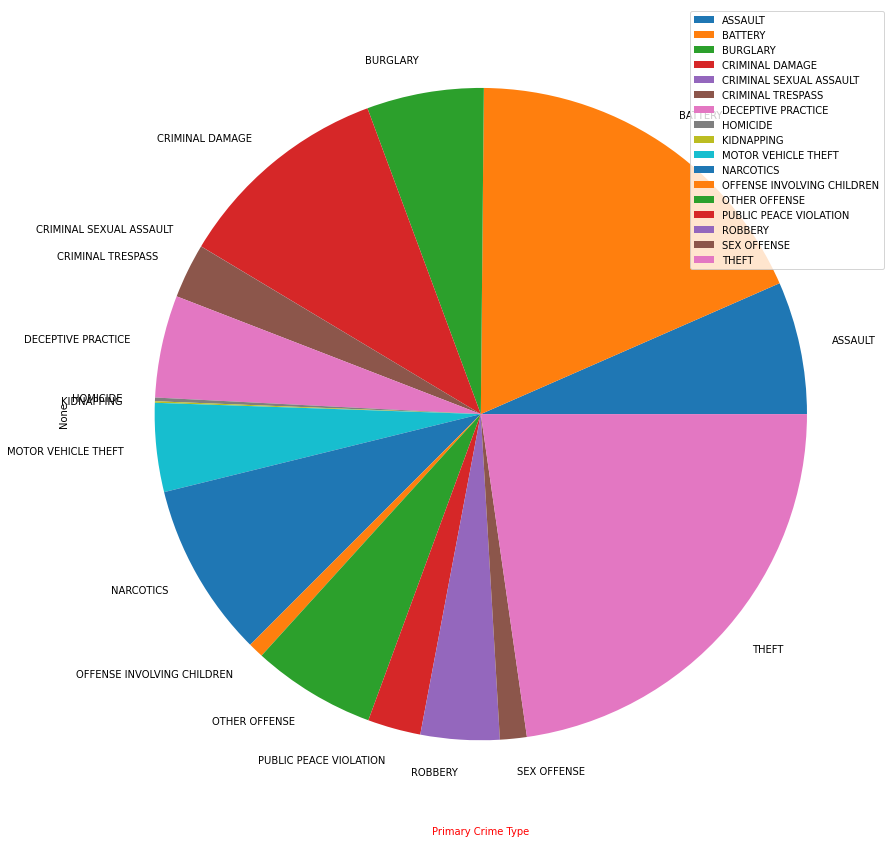

In [0]:
primaryVisualizeDF.plot.pie(figsize = (15,15))
plt.xlabel('Primary Crime Type', fontsize=10, color = 'red')
plt.legend()

# Preprocessing - specific to KNN model

In [0]:
data = data.replace(to_replace='None', value=np.nan).dropna()

**Label Encoding categorical variables**

In [0]:
# create an instance of label encoder for categorical variables
labelEncoder = LabelEncoder()

In [7]:
primaryEncoded = labelEncoder.fit_transform(data['Primary Type'])
primaryEncoded

array([15, 11, 11, ..., 12,  7,  7])

In [0]:
data['Primary Type'] = primaryEncoded

In [0]:
# create an instance of label encoder for categorical variables
labelEncoder2 = LabelEncoder()

In [10]:
locDiscEncoded = labelEncoder2.fit_transform(data['Location Description'])
locDiscEncoded

array([153, 133, 133, ...,  17,  37, 160])

In [0]:
data['Location Description'] = locDiscEncoded

In [0]:
# create an instance of label encoder for categorical variables
labelEncoder3 = LabelEncoder()

In [13]:
blockEncoded = labelEncoder2.fit_transform(data['Location Description'])
blockEncoded

array([153, 133, 133, ...,  17,  37, 160])

In [0]:
data['Block'] = locDiscEncoded

Use PCA to combine features

In [0]:
from sklearn.decomposition import PCA

In [0]:
location = data[['Latitude','Longitude']]
pca = PCA(n_components=1,random_state=123)

In [0]:
loc = pca.fit_transform(location)

In [0]:
data['Location'] = loc

In [19]:
data.head(5)

,Block,Primary Type,Location Description,Arrest,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Month,WeekDay,Location
0,153,15,153,False,511,5,9,49,2019,41.708589,-87.612583,4,4,-0.145575
1,133,11,133,False,1731,17,30,16,2019,41.940298,-87.732066,4,6,0.115124
2,133,11,133,False,1532,15,28,25,2019,41.884865,-87.755230,4,6,0.076679
3,133,1,133,False,513,5,9,49,2019,41.697609,-87.613508,4,5,-0.154883
4,160,0,160,False,2222,22,21,73,2019,41.729973,-87.653167,5,2,-0.107851


# Feature selection

Checking importance of features using an ExtraTreesClassifier

In [0]:
#taking a fraction of data
data_sample = data.sample(frac=0.1, random_state=123)

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()

In [0]:
X = data_sample.loc[:, data.columns != 'Primary Type']

model.fit(X,data_sample['Primary Type'])

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [0]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[0.06169809 0.06135702 0.04334372 0.06090417 0.01233077 0.03363271
 0.02964117 0.0924888  0.13077371 0.13091272 0.11603264 0.09655789
 0.13032659]


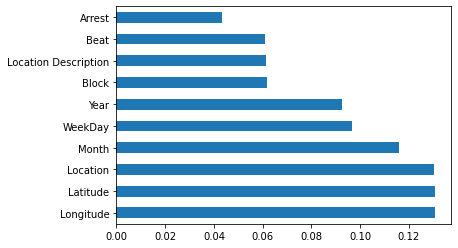

In [0]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#plot for top 10 features
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Find corelation between data to find dependency between data columns

In [0]:
corelation = data.corr()
corelation

,Block,Primary Type,Location Description,Arrest,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Month,WeekDay,Location
Block,1.000000,0.115127,1.000000,0.038168,0.014515,0.015081,-0.012151,0.012447,-0.029853,-0.038756,-0.015944,0.003408,0.002120,-0.026781
Primary Type,0.115127,1.000000,0.115127,0.039843,0.037460,0.035517,0.069905,-0.083323,-0.002116,0.087253,0.001026,0.007367,0.013911,0.070426
Location Description,1.000000,0.115127,1.000000,0.038168,0.014515,0.015081,-0.012151,0.012447,-0.029853,-0.038756,-0.015944,0.003408,0.002120,-0.026781
Arrest,0.038168,0.039843,0.038168,1.000000,-0.025085,-0.023351,-0.015733,0.020868,-0.064911,-0.026120,-0.034763,-0.030939,0.004530,-0.011070
Beat,0.014515,0.037460,0.014515,-0.025085,1.000000,0.980212,0.658243,-0.495143,-0.032528,0.634641,-0.532460,0.000218,0.002940,0.669146
District,0.015081,0.035517,0.015081,-0.023351,0.980212,1.000000,0.676552,-0.493580,-0.010671,0.638714,-0.552366,0.001527,0.002900,0.678232
Ward,-0.012151,0.069905,-0.012151,-0.015733,0.658243,0.676552,1.000000,-0.537736,0.016116,0.659018,-0.448022,0.005010,0.007056,0.664368
Community Area,0.012447,-0.083323,0.012447,0.020868,-0.495143,-0.493580,-0.537736,1.000000,-0.023129,-0.776675,0.246489,-0.007679,-0.008425,-0.701172
Year,-0.029853,-0.002116,-0.029853,-0.064911,-0.032528,-0.010671,0.016116,-0.023129,1.000000,0.014542,0.012898,0.006959,-0.002125,0.008039
Latitude,-0.038756,0.087253,-0.038756,-0.026120,0.634641,0.638714,0.659018,-0.776675,0.014542,1.000000,-0.548820,0.005587,0.006862,0.970047


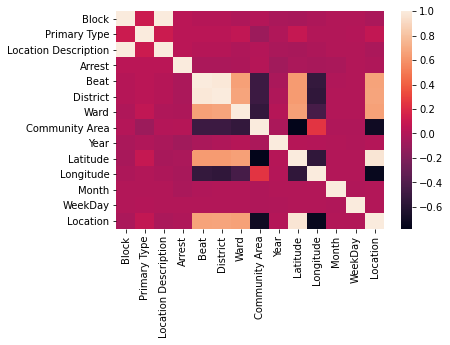

In [0]:
sns.heatmap(corelation)

**Based on the above outputs, we have decided that below selected columns are corelated and best params for our KNN model**

In [0]:
selected_columns = ['Latitude','Longitude','Location Description','Block','WeekDay']
#selected_columns = ['Latitude','Longitude']

# Splitting data in train and test

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[selected_columns], data['Primary Type'], test_size=0.3) # 70% training and 30% test

# Building initial KNN Classifier

**Initially we will build our classifier with 5 neighbours**

In [0]:
knn_5 = KNeighborsClassifier(n_neighbors=5) 
knn_5.fit(X_train,y_train)
pred_train = knn_5.predict(X_train)
pred_i = knn_5.predict(X_test)
print('Test accuracy ', metrics.accuracy_score(y_train, pred_train))
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Test accuracy  0.4785072963503379
Accuracy  0.2894782043888117
F1 score  0.28138838412651623


We will deploy Elbow method to get optimum number of neighbours

In [0]:
error_rate = []

krange = range(10,50,5)
for i in krange:
 
 knn = KNeighborsClassifier(n_neighbors=i, metric='manhattan', weights = 'uniform',n_jobs= -1) # haversine - if only lat long
 knn.fit(X_train,y_train)
 pred_train = knn.predict(X_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))
 print('Neighbours ',i)
 print('Test accuracy ', metrics.accuracy_score(y_train, pred_train))
 print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
 print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Neighbours  10
Test accuracy  0.42483123548737317
Accuracy  0.3126940196724146
F1 score  0.29331483794081864
Neighbours  15
Test accuracy  0.40340458973172694
Accuracy  0.3230170890878047
F1 score  0.29645248056689477
Neighbours  20
Test accuracy  0.3914327542826722
Accuracy  0.3290732898115002
F1 score  0.297561296424232
Neighbours  25
Test accuracy  0.38360282191523043
Accuracy  0.3323743969678045
F1 score  0.2969661610892852
Neighbours  30
Test accuracy  0.37859655982188256
Accuracy  0.3349372482507658
F1 score  0.29666538069152276
Neighbours  35
Test accuracy  0.3746784248092974
Accuracy  0.33626815637374174
F1 score  0.29599169369921274
Neighbours  40
Test accuracy  0.3714603572196403
Accuracy  0.33748417413738385
F1 score  0.2952621272392315
Neighbours  45
Test accuracy  0.36888678066975394
Accuracy  0.3387456930334354
F1 score  0.2949948644357232


Text(0, 0.5, 'Error Rate')

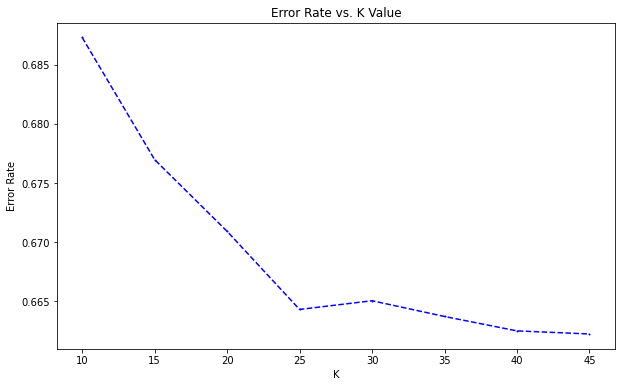

In [0]:
plt.figure(figsize=(10,6))

plt.plot(krange,error_rate, color= 'blue', linestyle= 'dashed', marker= 'o', markerfacecolor='red', markersize=1)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

K = 25, optimum

# Grid Search/ Random Search -KNN

**To find optimal paramteres for KNN Model, we will implement Grid search.**

In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [0]:
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [0]:
grid_params = {
    'weights' : ['uniform', 'distance'],
    'metric' : ['manhattan','jaccard'] #haversine - if only lat long
}

In [0]:
randomSearch = RandomizedSearchCV(
    KNeighborsClassifier(25),
    grid_params,
    verbose = 1,
    cv =3,
    random_state = 123
    )

In [0]:
#takes very long time
rs_results = randomSearch.fit(X_train_gs, y_train_gs)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  6.5min finished


In [0]:
rs_results.best_score_

0.3096858524213952

In [0]:
rs_results.best_params_

{'metric': 'manhattan', 'weights': 'uniform'}

# Oversmapling -SMOTE to balance dataset

In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
# Oversample 'Majority'
sm = SMOTE('minority', random_state=123)

In [0]:
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [0]:
#convert back to Dataframe
X_train_updated = pd.DataFrame(X_train_res, columns= selected_columns)
y_train_updated = pd.Series(y_train_res)

In [0]:
target_counts = y_train_updated.value_counts()
target_counts

16    466887
4     466887
1     374663
3     220576
10    177724
0     134718
12    125694
2     119325
6     103810
9      90189
14     79815
5      55519
13     54141
15     27124
11     15700
7       3706
8       1553
dtype: int64

In [0]:
knn = KNeighborsClassifier(n_neighbors=25, metric='manhattan', weights = 'uniform')

In [0]:
knn.fit(X_train_updated,y_train_updated)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [0]:
pred_i = knn.predict(X_test)

In [0]:
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Accuracy  0.3295920027209677
F1 score  0.2962310053713088


Oversampling the Minority classed helped with an increase in accuracy and F1 score

# Undersampling - Cluster Centroids

In [0]:
from imblearn.under_sampling import ClusterCentroids

In [0]:
# Undersample 'Majority'
cc = ClusterCentroids(sampling_strategy = 'majority')

In [0]:
X_cc, y_cc = cc.fit_sample(X_train, y_train)

In [0]:
#convert back to Dataframe
X_train_updated = pd.DataFrame(X_cc, columns= selected_columns)
y_train_updated = pd.Series(y_cc)

In [0]:
target_counts = y_train_updated.value_counts()
target_counts

1     374663
3     220576
10    177724
0     134718
12    125694
2     119325
6     103810
9      90189
14     79815
5      55519
13     54141
15     27124
11     15700
7       3706
8       1553
4         87
16        87
dtype: int64

In [0]:
knn = KNeighborsClassifier(n_neighbors=25, metric='manhattan', weights = 'uniform')

In [0]:
knn.fit(X_train_updated,y_train_updated)

In [0]:
pred_i = knn.predict(X_test)

In [0]:
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Accuracy  0.24927226626352664
F1 score  0.1955424370821218


Undersampling using cluster centroids does not help much in high dimensional data

# Random Sampling

In [0]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [0]:
# define oversampling strategy
over = RandomOverSampler(sampling_strategy= 'minority')

In [0]:
# fit and apply the transform
X_random, y_random = over.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
#convert back to Dataframe
X_train_updated = pd.DataFrame(X_random, columns= selected_columns)
y_train_updated = pd.Series(y_random)

In [0]:
target_counts_random = y_train_updated.value_counts()
target_counts_random

16    466887
4     466887
1     374663
3     220576
10    177724
0     134718
12    125694
2     119325
6     103810
9      90189
14     79815
5      55519
13     54141
15     27124
11     15700
7       3706
8       1553
dtype: int64

In [0]:
knn = KNeighborsClassifier(n_neighbors=25, metric='manhattan', weights = 'uniform')

In [0]:
knn.fit(X_train_updated,y_train_updated)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [0]:
pred_i = knn.predict(X_test)

In [0]:
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Accuracy  0.3328214455937272
F1 score  0.2973019662409677


OverSampling minority class improves model 

In [0]:
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy= 'majority')

In [0]:
# fit and apply the transform
X_train_updated, y_train_updated = under.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
y_train_updated = pd.Series(y_train_updated)
target_counts_random = y_train.value_counts()
target_counts_random

16    466887
1     374663
3     220576
10    177724
0     134718
12    125694
2     119325
6     103810
9      90189
14     79815
5      55519
13     54141
15     27124
11     15700
7       3706
8       1553
4         87
Name: Primary Type, dtype: int64

In [0]:
knn = KNeighborsClassifier(n_neighbors=25, metric='manhattan', weights = 'uniform')

In [0]:
knn.fit(X_train_updated,y_train_updated)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [0]:
pred_i = knn.predict(X_test)

In [0]:
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Accuracy  0.24930184199959277
F1 score  0.19552605947705762


Oversampling does not have significant impact on model

# Ensemble models

Here we will try ensemble of Various classification models 

In [0]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [0]:
#KNN with - 25 neighbours
knn = KNeighborsClassifier(25, metric='manhattan', weights = 'uniform',n_jobs= -1)

#random forest with 75 Decision Trees
rf = RandomForestClassifier(10, max_depth = 10, n_jobs= -1)

#Support Vector Classifier
svm = SVC(kernel = 'linear', random_state = 123, probability=True)

In [45]:
# can using previopusly trained KNN as well
knn.fit(X_train1,y_train1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=25, p=2,
                     weights='uniform')

In [39]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [40]:
rf.score(X_test, y_test)

0.3365866643006078

In [35]:
svm.fit(X_train1,y_train1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=123, shrinking=True, tol=0.001,
    verbose=False)

In [36]:
svm.score(X_test, y_test)

0.22814267790089626

In [0]:
#create a dictionary of our models
estimators=[('knn', knn), ('rf', rf), ('svm', svm)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

In [0]:
#fit model to training data
ensemble.fit(X_train, y_train)
#test our model on the test data
ensemble.score(X_test, y_test)

In [0]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
#spark imports




from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [0]:
spark = SparkSession.builder.appName("Project - Chicago crime")\
.config("spark.some.config.option", "some-value")\
.config("spark.driver.memory", "20g")\
.getOrCreate()

In [0]:
crimes_schema = StructType([StructField("Date", StringType(), True ),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("Year", IntegerType(), True),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),        
                            ])

In [0]:
data = spark.read.csv('/content/gdrive/My Drive/Colab Notebooks/my_csv2.csv',header = True,schema = crimes_schema)

In [10]:
dataset=data.withColumn("Day", F.split(data.Date, " ")[0])
dataset=dataset.withColumn("Day", F.to_date(dataset.Day, "MM/dd/yyyy"))
dataset=dataset.withColumn("Month", F.month(dataset.Day))
dataset=dataset.withColumn("Week", F.weekofyear(dataset.Day))
dataset=dataset.drop('Day')
dataset=dataset.drop('Date')
dataset.take(5)

[Row(Primary Type='PUBLIC PEACE VIOLATION', Location Description='AIRCRAFT', Arrest=False, Ward='41', Year=2019, Latitude=42.002816387, Longitude=-87.90609433, Month=1, Week=1),
 Row(Primary Type='BATTERY', Location Description='STREET', Arrest=False, Ward='42', Year=2019, Latitude=41.88336939, Longitude=-87.633860272, Month=3, Week=11),
 Row(Primary Type='THEFT', Location Description='RESIDENTIAL YARD (FRONT/BACK)', Arrest=False, Ward='4', Year=2019, Latitude=41.825346902, Longitude=-87.606780575, Month=3, Week=11),
 Row(Primary Type='BATTERY', Location Description='RESIDENCE', Arrest=False, Ward='49', Year=2019, Latitude=42.016541612, Longitude=-87.672499325, Month=3, Week=11),
 Row(Primary Type='OTHER OFFENSE', Location Description='STREET', Arrest=False, Ward='4', Year=2019, Latitude=41.825298645, Longitude=-87.6069609, Month=3, Week=11)]

In [11]:
dataset_new=dataset.drop(dataset['Latitude'])
dataset_new=dataset_new.drop(dataset_new['Longitude'])
dataset_new.take(5)

[Row(Primary Type='PUBLIC PEACE VIOLATION', Location Description='AIRCRAFT', Arrest=False, Ward='41', Year=2019, Month=1, Week=1),
 Row(Primary Type='BATTERY', Location Description='STREET', Arrest=False, Ward='42', Year=2019, Month=3, Week=11),
 Row(Primary Type='THEFT', Location Description='RESIDENTIAL YARD (FRONT/BACK)', Arrest=False, Ward='4', Year=2019, Month=3, Week=11),
 Row(Primary Type='BATTERY', Location Description='RESIDENCE', Arrest=False, Ward='49', Year=2019, Month=3, Week=11),
 Row(Primary Type='OTHER OFFENSE', Location Description='STREET', Arrest=False, Ward='4', Year=2019, Month=3, Week=11)]

In [0]:
dataset_new=dataset_new.drop(dataset_new['Year'])
dataset_new=dataset_new.drop(dataset_new['Month'])

In [0]:
targetDf = dataset_new.withColumn("Primary Type", \
              when((dataset_new["Primary Type"] == 'KIDNAPPING') | (dataset_new["Primary Type"] == 'HOMICIDE'),'OTHER OFFENSE').otherwise(dataset_new['Primary Type']))

In [26]:
d=targetDf.groupby('Primary Type').count()
d.show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|OFFENSE INVOLVING...| 22415|
|PUBLIC PEACE VIOL...| 77058|
|   CRIMINAL TRESPASS| 79520|
|             ASSAULT|192574|
| MOTOR VEHICLE THEFT|128894|
|               THEFT|666384|
|             BATTERY|535709|
|             ROBBERY|114459|
|  DECEPTIVE PRACTICE|148325|
|         SEX OFFENSE| 38939|
|     CRIMINAL DAMAGE|315193|
|           NARCOTICS|253623|
|       OTHER OFFENSE|187053|
|            BURGLARY|169950|
+--------------------+------+



In [0]:
dataset_new_pd=targetDf.toPandas()

**Predicting type of crime based on a week**

In [0]:
dataset_new_a=dataset_new_pd.drop('Location Description',axis=1)

In [0]:
le_primarytype = LabelEncoder()
le_arrest = LabelEncoder()
dataset_new_a['new_arrest']=le_arrest.fit_transform(dataset_new_a['Arrest'])
dataset_new_a['new_primarytype']=le_primarytype.fit_transform(dataset_new_a['Primary Type'])

my_dataset_new=dataset_new_pd.drop(['Primary Type','Arrest'], axis=1)
my_dataset_new.head()

,Ward,Week,new_arrest,new_primarytype
0,41,1,0,10
1,42,11,0,1
2,4,11,0,13
3,49,11,0,1
4,4,11,0,9


In [0]:
accuracy_rate = []
# Might take some time
X=my_dataset_new.iloc[:,:3]
y=my_dataset_new.iloc[:,3:]

X_train, X_test, y_train, y_test= train_test_split(X,y,random_state=123, test_size=0.2)

for i in range(1,50,3):
    knn= KNeighborsClassifier(n_neighbors=i, p=2, metric='manhattan')
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    accuracy_rate.append(accuracy_score(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

**Plotting neighbors(Elbow Method):**

Text(0, 0.5, 'Accuracy Rate')

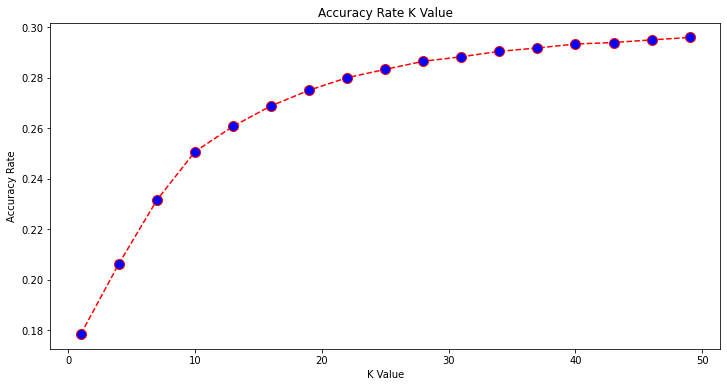

In [0]:
plt.figure(figsize=(12, 6))
  plt.plot(range(1, 50,3), accuracy_rate, color='red', linestyle='dashed', marker='o',
          markerfacecolor='blue', markersize=10)
  plt.title('Accuracy Rate K Value')
  plt.xlabel('K Value')
  plt.ylabel('Accuracy Rate')

**For k=20 accuracy=28%**

In [0]:
#x[:, 0] = labelencoder.fit_transform(my_dataset_new_drop_arrest[:, 0])
X=my_dataset_new.iloc[:,:3]
y=my_dataset_new.iloc[:,3:]

X_train, X_test, y_train, y_test= train_test_split(X,y,random_state=123, test_size=0.2)
knn= KNeighborsClassifier(n_neighbors=20, p=2, metric='euclidean')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.2833475341672063


**Adding new feature(Location Description) to the exisiting data for better prediction**

In [15]:
le_primarytype = LabelEncoder()
le_arrest = LabelEncoder()
le_locationdescription = LabelEncoder()
dataset_new_pd['new_arrest']=le_arrest.fit_transform(dataset_new_pd['Arrest'])
dataset_new_pd['new_locationdescription']=le_locationdescription.fit_transform(dataset_new_pd['Location Description'])
dataset_new_pd['new_primarytype']=le_primarytype.fit_transform(dataset_new_pd['Primary Type'])
my_dataset_new=dataset_new_pd.drop(['Primary Type','Arrest','Location Description'], axis=1)
my_dataset_new.head()

,Ward,Week,new_arrest,new_locationdescription,new_primarytype
0,41,1,0,3,10
1,42,11,0,142,1
2,4,11,0,125,13
3,49,11,0,122,1
4,4,11,0,142,9


**[Accuracy achieved= 36%]**

In [97]:
#x[:, 0] = labelencoder.fit_transform(my_dataset_new_drop_arrest[:, 0])
X=my_dataset_new.iloc[:,:4]
y=my_dataset_new.iloc[:,4:]

X_train, X_test, y_train, y_test= train_test_split(X,y,random_state=123, test_size=0.2)
knn= KNeighborsClassifier(n_neighbors=20, p=2, metric='euclidean')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.36494658885362274


**Applying Random OverSampling technique**

In [16]:
# define oversampling strategy
over = RandomOverSampler(sampling_strategy= 'minority') 

X=my_dataset_new.iloc[:,:4]
y=my_dataset_new.iloc[:,4:]

# fit and apply the transform
X_random, y_random = over.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**[Accuracy Achieved=41%]**

In [17]:
X_train, X_test, y_train, y_test= train_test_split(X_random,y_random,random_state=123, test_size=0.2)
knn= KNeighborsClassifier(n_neighbors=20, p=2, metric='manhattan')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.4106584519307847


**F1 Score**

In [0]:
print('F1 score ', f1_score(y_test, y_pred, average = 'weighted'))

F1 score  0.3164452799354284


**Applying Random UnderSampling technique**

In [21]:
# define oversampling strategy
over = RandomUnderSampler(sampling_strategy= 'majority') 

X=my_dataset_new.iloc[:,:4]
y=my_dataset_new.iloc[:,4:]

# fit and apply the transform
X_random, y_random = over.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [22]:
X_train, X_test, y_train, y_test= train_test_split(X_random,y_random,random_state=123, test_size=0.2)
knn= KNeighborsClassifier(n_neighbors=20, p=2, metric='manhattan')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.35839825381758694


**Random UnderSampling technique with sampling_strategy= 'not minority'**

In [110]:
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy= 'not minority') 

X=my_dataset_new.iloc[:,:4]
y=my_dataset_new.iloc[:,4:]

# fit and apply the transform
X_random, y_random = under.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [111]:
X_train, X_test, y_train, y_test= train_test_split(X_random,y_random,random_state=123, test_size=0.2)
knn= KNeighborsClassifier(n_neighbors=20, p=2, metric='euclidean')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.26398139001306525


**Random OverSampling technique with sampling_strategy= 'not majority'**

In [112]:
# define oversampling strategy
over = RandomOverSampler(sampling_strategy= 'not majority') 

X=my_dataset_new.iloc[:,:4]
y=my_dataset_new.iloc[:,4:]

# fit and apply the transform
X_random, y_random = over.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [113]:
X_train, X_test, y_train, y_test= train_test_split(X_random,y_random,random_state=123, test_size=0.2)
knn= KNeighborsClassifier(n_neighbors=20, p=2, metric='euclidean')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.35551290653826945
